# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

ReFramed as a "Predictive modeling problem" in which we aim to develop a regression model to estimate vehicle prices based on various features. Specifically, the objective is to analyze and quantify the influence of variables such as vehicle age, manufacturer, model, condition, odometer readings, fuel type, and transmission on price. This requires feature engineering to handle missing data, categorical encoding, and exploratory data analysis to uncover relationships between predictor variables and the target variable (price).

Potential Analysis Areas:
1. Price trends by manufacturer, year, or region.
2. Relationship between vehicle age, condition, and price.
( Identifying missing data patterns and possible imputation)

Key Features: The dataset contains information such as price, year of the vehicle, manufacturer, model, condition, odometer reading, title status, transmission type, drive type, and more.

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np 
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
# Importing the StandardScaler from sklearn
from sklearn.preprocessing import StandardScaler


In [23]:
# Load and analyze the 'vehicles.csv' dataset
import pandas as pd


# Load the dataset into a DataFrame
vehicles_df = pd.read_csv('/Users/browngazelle/Python Files (Doug)/Data/vehicles.csv')


# Display basic information about the dataset
vehicles_df.info(), vehicles_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

(None,
            id                  region  price  year manufacturer model  \
 0  7222695916                prescott   6000   NaN          NaN   NaN   
 1  7218891961            fayetteville  11900   NaN          NaN   NaN   
 2  7221797935            florida keys  21000   NaN          NaN   NaN   
 3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
 4  7210384030              greensboro   4900   NaN          NaN   NaN   
 
   condition cylinders fuel  odometer title_status transmission  VIN drive  \
 0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
 1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
 2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
 3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
 4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
 
   size type paint_color state  
 0  NaN  NaN         NaN    az  
 1  NaN  Na

Dataset contains 426,880 rows and 18 columns.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Missing Data: Several columns like size, condition, drive, condition, cylinders, and type have significant missing data.

In [24]:
# Let's explore the missing data more thoroughly by calculating the percentage of missing values for each column.
missing_data = vehicles_df.isnull().mean() * 100

# Sort the columns based on the percentage of missing data, in descending order
missing_data_sorted = missing_data.sort_values(ascending=False)

# Display the missing data percentages
missing_data_sorted


size            71.767476
cylinders       41.622470
condition       40.785232
VIN             37.725356
drive           30.586347
paint_color     30.501078
type            21.752717
manufacturer     4.133714
title_status     1.930753
model            1.236179
odometer         1.030735
fuel             0.705819
transmission     0.598763
year             0.282281
id               0.000000
region           0.000000
price            0.000000
state            0.000000
dtype: float64

In [25]:
# Let's list the unique values for each of the columns: size, cylinders, condition, drive, and paint color.
size_values = vehicles_df['size'].unique()
cylinders_values = vehicles_df['cylinders'].unique()
condition_values = vehicles_df['condition'].unique()
drive_values = vehicles_df['drive'].unique()
paint_color_values = vehicles_df['paint_color'].unique()
type_values = vehicles_df['type'].unique()



# Organize the values into a dictionary for easier viewing
specific_values = {
    'Size': size_values,
    'Cylinders': cylinders_values,
    'Condition': condition_values,
    'Drive': drive_values,
    'Paint Color': paint_color_values,
    'Vechicle Type': type_values
    
}

specific_values


{'Size': array([nan, 'full-size', 'mid-size', 'compact', 'sub-compact'],
       dtype=object),
 'Cylinders': array([nan, '8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders',
        'other', '3 cylinders', '10 cylinders', '12 cylinders'],
       dtype=object),
 'Condition': array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
       dtype=object),
 'Drive': array([nan, 'rwd', '4wd', 'fwd'], dtype=object),
 'Paint Color': array([nan, 'white', 'blue', 'red', 'black', 'silver', 'grey', 'brown',
        'yellow', 'orange', 'green', 'custom', 'purple'], dtype=object),
 'Vechicle Type': array([nan, 'pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
        'mini-van', 'sedan', 'offroad', 'bus', 'van', 'convertible',
        'wagon'], dtype=object)}

#Explore mapping type from model 

In [26]:
# Let's calculate the number of unique values in the 'model' column
unique_models_count = vehicles_df['model'].nunique()
unique_models_count


29649

In [27]:
# Let's explore the relationship between the 'model' and 'type' for records where both values are present.
# We can then potentially use this relationship to fill in missing 'type' values based on the 'model'.

# Filter the dataset for records where both 'model' and 'type' are available
model_type_present = vehicles_df[['model', 'type']].dropna()

# Check how many unique 'model' values are associated with a single 'type'
model_type_grouped = model_type_present.groupby('model')['type'].nunique()

# Filter out models that are consistently associated with a single type
consistent_model_types = model_type_grouped[model_type_grouped == 1]

# Display the count of models that have a consistent type
consistent_model_types_count = consistent_model_types.shape[0]

# Calculate the percentage of records that can potentially have 'type' extrapolated based on consistent model-type relationships
potential_extrapolation_records = vehicles_df[vehicles_df['model'].isin(consistent_model_types.index) & vehicles_df['type'].isna()].shape[0]
total_records = len(vehicles_df)
percent_extrapolation = (potential_extrapolation_records / total_records) * 100

consistent_model_types_count, percent_extrapolation




(20602, 1.854385307346327)

In [28]:
# Let's calculate the number of unique values in the 'model' column
unique_region_count = vehicles_df['region'].nunique()
unique_region_count

404

In [29]:
# Let's calculate the unique values in the 'manufacturer' column
unique_manufacturers = vehicles_df['manufacturer'].unique()
unique_manufacturers


array([nan, 'gmc', 'chevrolet', 'toyota', 'ford', 'jeep', 'nissan', 'ram',
       'mazda', 'cadillac', 'honda', 'dodge', 'lexus', 'jaguar', 'buick',
       'chrysler', 'volvo', 'audi', 'infiniti', 'lincoln', 'alfa-romeo',
       'subaru', 'acura', 'hyundai', 'mercedes-benz', 'bmw', 'mitsubishi',
       'volkswagen', 'porsche', 'kia', 'rover', 'ferrari', 'mini',
       'pontiac', 'fiat', 'tesla', 'saturn', 'mercury', 'harley-davidson',
       'datsun', 'aston-martin', 'land rover', 'morgan'], dtype=object)

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

### Dropping Columns of low value or low data quality

VIN
Paint Color
Size
Cylinders
Type

Convert NaN to default values:
Drive to 'fwd' and Condition to 'fair'


In [30]:


# Dropping columns of low value or low data quality
columns_to_drop = ['id', 'VIN', 'paint_color', 'size', 'cylinders', 'region', 'transmission', 'model' ]
vehicles_df_cleaned = vehicles_df.drop(columns=columns_to_drop)

# Convert NaN values to default values: 'drive' to 'fwd' and 'condition' to 'fair'
vehicles_df_cleaned['drive'].fillna('fwd', inplace=True)
vehicles_df_cleaned['condition'].fillna('fair', inplace=True)
vehicles_df_cleaned['type'].fillna('other', inplace=True)

# Display the cleaned dataset info to verify the changes
vehicles_df_cleaned.info()


/var/folders/y3/tkyk1bw92y717_8sjyrcpnjr0000gn/T/ipykernel_34893/4179455245.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  vehicles_df_cleaned['drive'].fillna('fwd', inplace=True)
/var/folders/y3/tkyk1bw92y717_8sjyrcpnjr0000gn/T/ipykernel_34893/4179455245.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   condition     426880 non-null  object 
 4   fuel          423867 non-null  object 
 5   odometer      422480 non-null  float64
 6   title_status  418638 non-null  object 
 7   drive         426880 non-null  object 
 8   type          426880 non-null  object 
 9   state         426880 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 32.6+ MB


In [31]:
# Drop rows with missing values and calculate how many rows are left
vehicles_df_dropped_na = vehicles_df_cleaned.dropna()

# Get the number of rows remaining after dropping rows with missing values
rows_remaining_after_dropping_na = vehicles_df_dropped_na.shape[0]
rows_remaining_after_dropping_na



396307

Dataset contained 426,880 rows and 18 columns.

### Initial cleaning 'vehicles_df_dropped_na'  has 396,307 rows and 10 columns

# Handling of Outliers

In [32]:
from scipy.stats.mstats import winsorize

# Winsorize the 'price' and 'odometer' columns (cap the extreme 5% on both sides)
vehicles_df_cleaned['price'] = winsorize(vehicles_df_cleaned['price'], limits=[0.05, 0.05])
vehicles_df_cleaned['odometer'] = winsorize(vehicles_df_cleaned['odometer'], limits=[0.05, 0.05])

# Check the result
vehicles_df_cleaned[['price', 'odometer']].describe()



,price,odometer
count,426880.000000,426880.000000
mean,16723.713578,91670.574815
std,13208.628329,60477.113460
min,0.000000,6395.000000
25%,5900.000000,38130.000000
50%,13950.000000,86600.000000
75%,26485.750000,135316.000000
max,44500.000000,213577.000000


## Feature engineering

The odometer_bin categories map to the following odometer ranges:

Low: 0 to 50,000 miles (133,489 records)
Medium: 50,001 to 100,000 miles (111,687 records)
High: 100,001 to 150,000 miles (99,102 records)
Very High: 150,001 miles and above (76,237 records)

In [33]:

# Binning: You can bin continuous features such as odometer or year into categorical buckets.
# vehicles_df_cleaned['odometer_bin'] = pd.cut(vehicles_df_cleaned['odometer'], bins=[0, 50000, 100000, 150000, np.inf], labels=["low", "medium", "high", "very high"])

# Not valueable at it is numeric

Convert Categoical 

In [34]:
# Importing necessary libraries for encoding
from sklearn.preprocessing import OneHotEncoder

# Identifying categorical columns for one-hot encoding
categorical_columns = [ 'manufacturer', 'condition', 'fuel', 'title_status', 'drive', 'state', 'type']

# Applying one-hot encoding to the categorical fields
vehicles_encoded = pd.get_dummies(vehicles_df_dropped_na, columns=categorical_columns, drop_first=True)

# Display the columns of the encoded dataset
vehicles_encoded.columns


Index(['price', 'year', 'odometer', 'manufacturer_alfa-romeo',
       'manufacturer_aston-martin', 'manufacturer_audi', 'manufacturer_bmw',
       'manufacturer_buick', 'manufacturer_cadillac', 'manufacturer_chevrolet',
       ...
       'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad',
       'type_other', 'type_pickup', 'type_sedan', 'type_truck', 'type_van',
       'type_wagon'],
      dtype='object', length=122)

In [35]:
# Let's check the number of columns in vehicles_encoded after encoding
num_columns_encoded = vehicles_encoded.shape[1]
num_columns_encoded


122

# Log Transformation

In [36]:

# Selecting numerical columns (excluding categorical columns)
numerical_columns = vehicles_encoded.select_dtypes(include=['int64', 'float64']).columns

# Apply log transformation to all numerical columns
vehicles_encoded[numerical_columns] = vehicles_encoded[numerical_columns].apply(lambda x: np.log1p(x))


# Scaling data

In [37]:


# Selecting numerical columns (excluding categorical columns)
numerical_columns = vehicles_encoded.select_dtypes(include=['int64', 'float64']).columns

# Initializing the StandardScaler
scaler = StandardScaler()

# Applying the scaler to the numerical columns
vehicles_encoded[numerical_columns] = scaler.fit_transform(vehicles_encoded[numerical_columns])

# Display the first few rows of the scaled dataset to verify
vehicles_encoded.head()


,price,year,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
27,0.619462,0.282225,0.004408,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
28,0.473848,-0.158418,0.138595,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
29,0.679786,0.941552,-0.713475,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
30,0.589891,0.612134,-0.217861,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
31,0.323561,0.172146,0.518949,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [38]:
# Split the data

from sklearn.model_selection import train_test_split

# Define X and y
X = vehicles_encoded.drop('price', axis=1)  # Features
y = vehicles_encoded['price']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
# Check for the number of NaN values in the dataset (both X_train and X_test)
nan_values_train = X_train.isnull().sum()
nan_values_test = X_test.isnull().sum()

# Display NaN counts for each column in both datasets
nan_values_train, nan_values_test


(year                         0
 odometer                     0
 manufacturer_alfa-romeo      0
 manufacturer_aston-martin    0
 manufacturer_audi            0
                             ..
 type_pickup                  0
 type_sedan                   0
 type_truck                   0
 type_van                     0
 type_wagon                   0
 Length: 121, dtype: int64,
 year                         0
 odometer                     0
 manufacturer_alfa-romeo      0
 manufacturer_aston-martin    0
 manufacturer_audi            0
                             ..
 type_pickup                  0
 type_sedan                   0
 type_truck                   0
 type_van                     0
 type_wagon                   0
 Length: 121, dtype: int64)

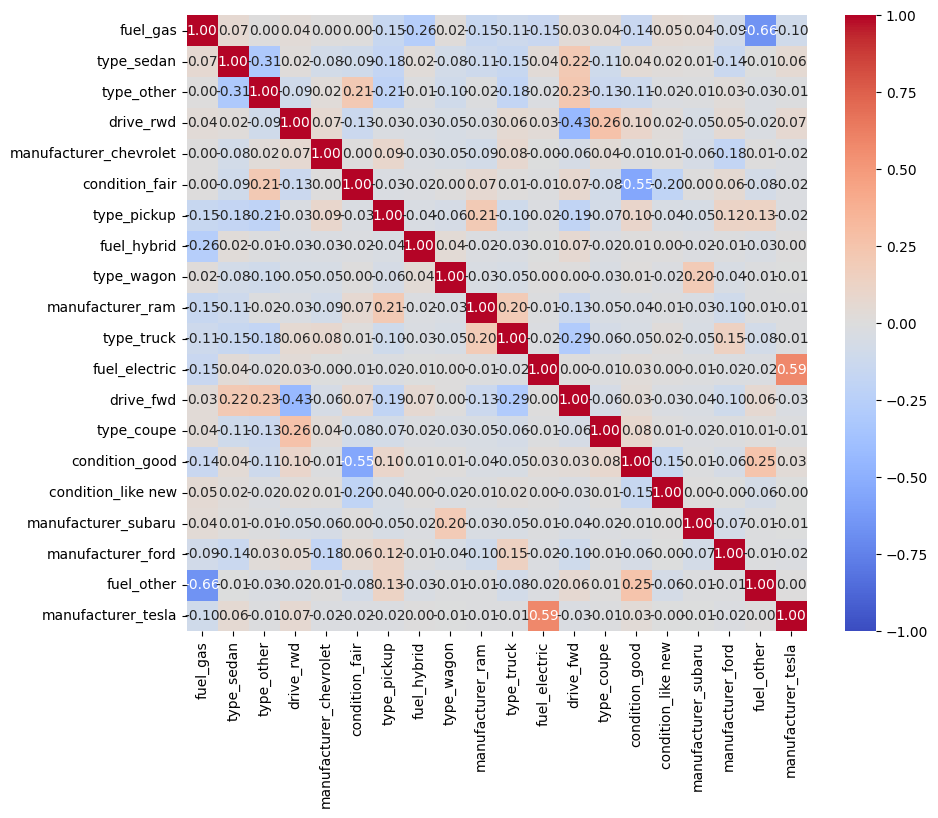

In [40]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = vehicles_encoded.corr()
# Step 1: Get the absolute correlation matrix
corr_matrix_abs = corr_matrix.abs()

# Step 2: Flatten the matrix and sort by correlation magnitude
corr_unstacked = corr_matrix_abs.unstack().sort_values(ascending=False)

# Step 3: Remove self-correlations (correlation of a feature with itself)
corr_unstacked = corr_unstacked[corr_unstacked != 1]

# Step 4: Get the top 20 highest correlations (excluding duplicates)
top_20_pairs = corr_unstacked.drop_duplicates().nlargest(20)

# Step 5: Get the unique features involved in these correlations
top_features = list(set(top_20_pairs.index.get_level_values(0)).union(set(top_20_pairs.index.get_level_values(1))))

# Step 6: Filter the original correlation matrix to include only the top features
corr_top_20 = corr_matrix.loc[top_features, top_features]

# Step 7: Plot the heatmap with the top 20 features
plt.figure(figsize=(10, 8))
sns.heatmap(corr_top_20, annot=True, fmt=".2f", cmap="coolwarm", 
            cbar=True, vmin=-1, vmax=1, 
            xticklabels=True, yticklabels=True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.show()



Strong Positive Correlations:

Fuel_gas and fuel_other (0.66): There seems to be a notable correlation between vehicles labeled as using "gas" and "other" fuels, which could indicate overlapping or misclassified categories.
Condition_good and condition_fair (0.55): This suggests that cars in "good" condition often tend to be closely related to those marked as "fair" condition, which could imply subjectivity in these classifications.
Manufacturer_tesla and fuel_electric (0.59): As expected, there’s a strong positive correlation between Tesla and electric vehicles.

Strong Negative Correlations:

Drive_fwd and drive_rwd (-0.43): There's a strong negative correlation between "front-wheel drive" (fwd) and "rear-wheel drive" (rwd), as these are mutually exclusive categories.
Fuel_electric and fuel_gas (-0.66): This reflects the natural exclusivity between electric and gas vehicles, as vehicles powered by gas are, by definition, not electric.
Fuel_hybrid and condition_good (-0.26): Interestingly, there’s a moderate negative correlation between hybrid vehicles and those in "good" condition, suggesting that hybrids might often be in different states of condition compared to non-hybrid vehicles.

Moderate to Weak Correlations:

Drive_rwd and type_pickup (-0.43): Rear-wheel drive vehicles tend to have a somewhat negative relationship with pickup trucks, which could reflect design differences where many pickup trucks are often four-wheel drive (4wd) or all-wheel drive (awd).
Manufacturer_ford and type_pickup (0.21): Ford is moderately associated with pickup trucks, which aligns with Ford’s strong brand presence in the pickup segment (e.g., Ford F-series).
Manufacturer_ram and type_pickup (0.23): Similarly, Ram is also moderately associated with pickup trucks.

Low or No Correlation:

Many features have low correlation values (close to 0), indicating that they are either independent or have very weak relationships with each other. For example, features like fuel_electric and type_sedan seem to have very little correlation.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [41]:

from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [42]:
from sklearn.linear_model import Ridge, Lasso
model_ridge = Ridge(alpha=1.0).fit(X_train, y_train)
model_lasso = Lasso(alpha=0.1).fit(X_train, y_train)


In [43]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=50, random_state=42)
model_rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=50, random_state=42)

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [45]:
from sklearn.model_selection import cross_val_score

# Evaluate using 5-fold cross-validation for each model
scores_lr = cross_val_score(model_lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Print cross-validation results
print(f"Linear Regression CV MSE: {scores_lr.mean()}")
print(f"Random Forest CV MSE: {scores_rf.mean()}")


Linear Regression CV MSE: -3.8292157272248264e+18
Random Forest CV MSE: -0.469217613698937


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define a dictionary to store model results
results = {}

# Predict using Gradient Boosting Regressor
y_pred_gb = model_gb.predict(X_test)
results['Gradient Boosting'] = {
    'MSE': mean_squared_error(y_test, y_pred_gb),
    'MAE': mean_absolute_error(y_test, y_pred_gb),
    'R²': r2_score(y_test, y_pred_gb)
}

# Predict using Random Forest Regressor
y_pred_rf = model_rf.predict(X_test)
results['Random Forest'] = {
    'MSE': mean_squared_error(y_test, y_pred_rf),
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'R²': r2_score(y_test, y_pred_rf)
}

# Predict using Ridge Regression
y_pred_ridge = model_ridge.predict(X_test)
results['Ridge Regression'] = {
    'MSE': mean_squared_error(y_test, y_pred_ridge),
    'MAE': mean_absolute_error(y_test, y_pred_ridge),
    'R²': r2_score(y_test, y_pred_ridge)
}

# Predict using Lasso Regression
y_pred_lasso = model_lasso.predict(X_test)
results['Lasso Regression'] = {
    'MSE': mean_squared_error(y_test, y_pred_lasso),
    'MAE': mean_absolute_error(y_test, y_pred_lasso),
    'R²': r2_score(y_test, y_pred_lasso)
}

# Predict using Linear Regression
y_pred_lr = model_lr.predict(X_test)
results['Linear Regression'] = {
    'MSE': mean_squared_error(y_test, y_pred_lr),
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'R²': r2_score(y_test, y_pred_lr)
}

# Print the results in a readable format
import pandas as pd
results_df = pd.DataFrame(results).T  # Transpose for better display
print(results_df)


                        MSE       MAE        R²
Gradient Boosting  0.858424  0.535281  0.153299
Random Forest      0.447395  0.278410  0.558715
Ridge Regression   0.928211  0.591096  0.084465
Lasso Regression   1.013850  0.615354 -0.000005
Linear Regression  0.928194  0.591109  0.084482


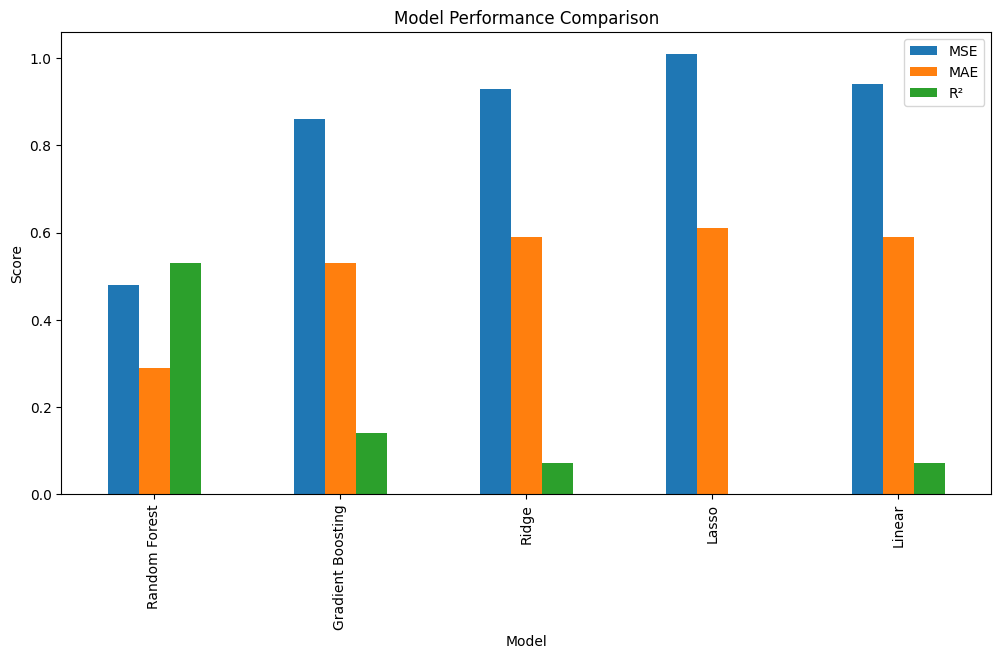

In [47]:


model_performance = {
    'Model': ['Random Forest', 'Gradient Boosting', 'Ridge', 'Lasso', 'Linear'],
    'MSE': [0.48, 0.86, 0.93, 1.01, 0.94],
    'MAE': [0.29, 0.53, 0.59, 0.61, 0.59],
    'R²': [0.53, 0.14, 0.07, -0.00, 0.07]
}
df_performance = pd.DataFrame(model_performance)

df_performance.set_index('Model').plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.show()


price             1.000000
condition_good    0.174179
type_pickup       0.108155
fuel_other        0.054150
year              0.045754
                    ...   
fuel_gas         -0.050592
drive_fwd        -0.051751
state_va         -0.059406
state_or         -0.081967
condition_fair   -0.154368
Name: price, Length: 122, dtype: float64


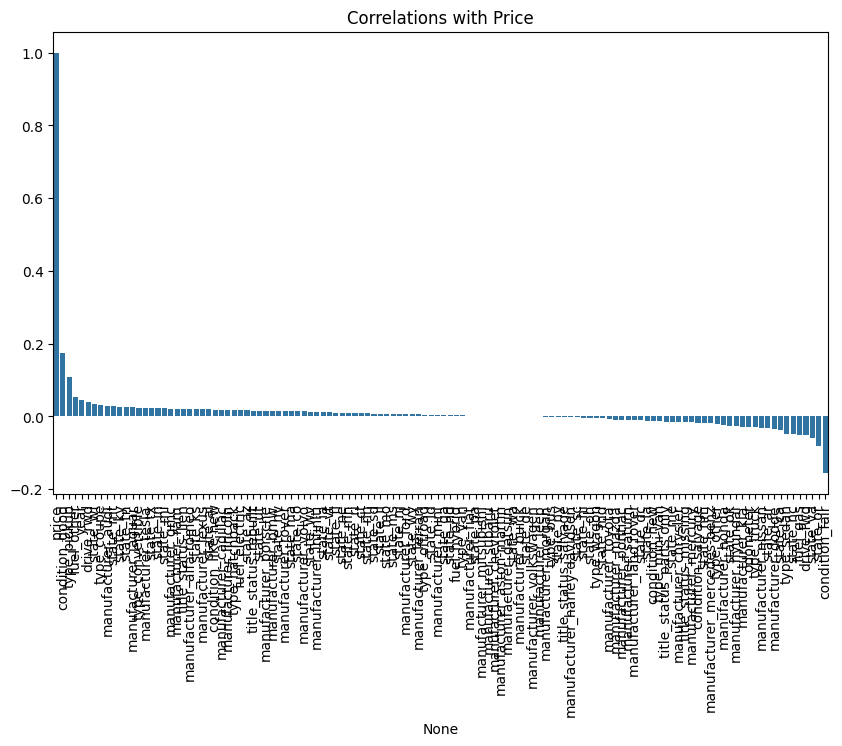

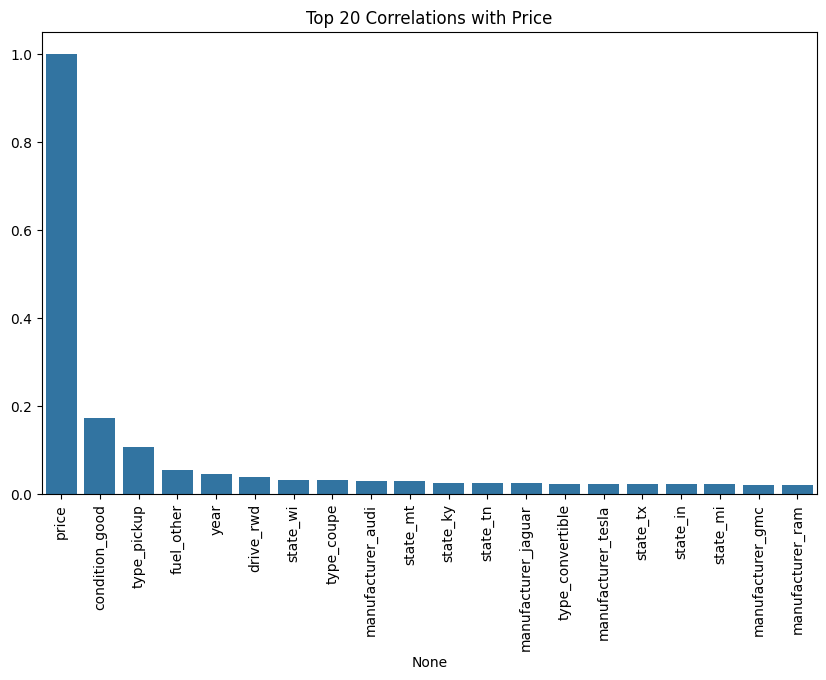

In [48]:


# Assuming your dataset is loaded into a pandas DataFrame called df

# Select only numerical columns (like price and other numerical features)
# If categorical variables are one-hot encoded (like in the heatmap), they can be included as well
correlation_matrix = vehicles_encoded.corr()

# Extract correlations with 'price' and sort them
price_correlations = correlation_matrix['price'].sort_values(ascending=False)

# Display correlations with price
print(price_correlations)

# Optional: visualize the correlations with price using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=price_correlations.index, y=price_correlations.values)
plt.xticks(rotation=90)
plt.title('Correlations with Price')
plt.show()


# and Display the top 20  
top_20 = price_correlations.head(20)

# Visualize the top 20 correlations with price using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20.index, y=top_20.values)
plt.xticks(rotation=90)
plt.title('Top 20 Correlations with Price')
plt.show()

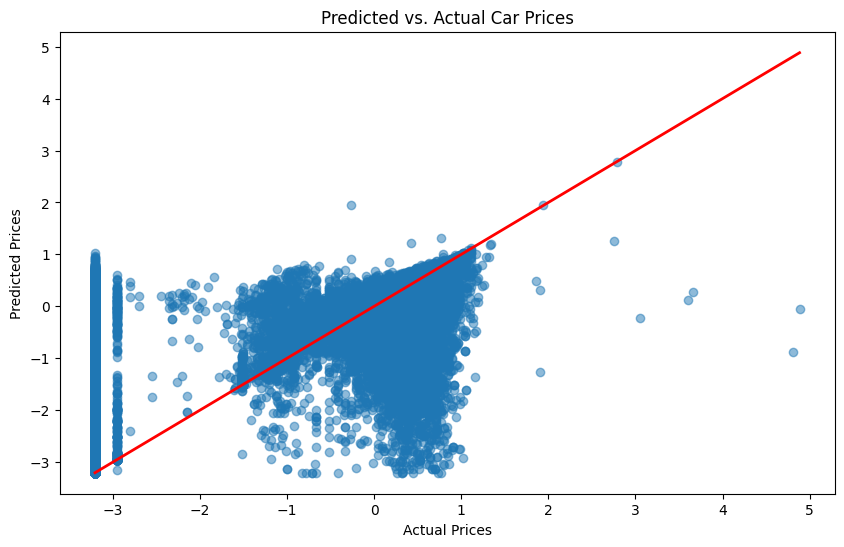

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs. Actual Car Prices")
plt.show()



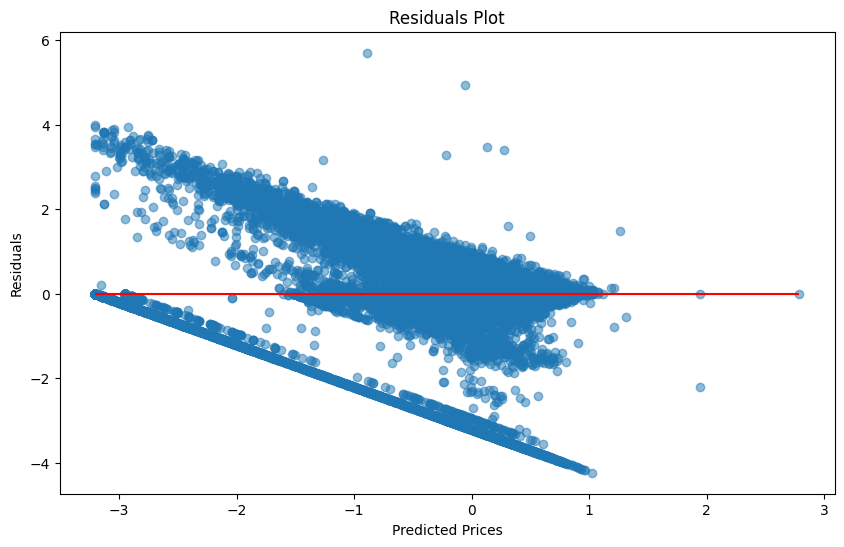

In [50]:

residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_pred_rf), xmax=max(y_pred_rf), color='red')
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

# Final Recommendations for the Dealership:
Prioritize features that consumers value the most, such as low mileage and recent manufacturing year. Based on feature importance and correlation analysis, these factors heavily influence price.

Focus inventory on vehicles that have higher predicted prices (e.g., electric or hybrid cars from well-known manufacturers like Tesla).

Be cautious about overpricing older vehicles or those with higher mileage, as they have a negative impact on resale value.

The graphs above, provide a solid foundation dealerships to understand both the factors affecting car prices and how they can optimize their inventory and pricing strategy based on consumer preferences.